# 연구목표 수립/확인/파악

- 유사서비스
  - 구글번역, 파파고, 카카오번역
  - **언어 감지 파트 구현(머신러닝)**, 기계 번역(딥러닝) 생략 혹은 api 연동해서 표현
  - 언어 감지 제공 서비스 언어들중에서 같은 문자를 사용하는 언어권만 수행
    - 알파벳 : 영어, 프랑스어, 인도네이사어, 타갈리아어
    - 기타 문자 사용 국가 : 한국어, 중국어, 일본어 => 문자가 상이하고, 데이터로 표현되는 구간이 다르다 => 로직으로 해결
    - 문자들이 서로 섞여 있다면 이 텍스트를 영어? 한국어? 문제가 실제상으로는 존재 (배제)

- 알파벳을 사용하는 국가들을 어떻게 구분하는가?
  - 논문등을 차용하면 시간 및 객관성을 답보 받을수 있다
  - **국가별로 a-z의 사용 빈도가 다르다**
  - 사용빈도를 학습시켜서 특정 양의 텍스트가 입력되면 이 글이 어느 나라 글인지 예측할수 있다

- 방법
  - 영어, 프랑스어, 인도네시아어, 타갈리아어에 **동일한 내용**을 담은 텍스트를 제공
  - 윈도우 설명서,..
  - 텍스트 -> a-z까지 정규화 처리 -> 빈도계산 ->a가 몇회, b가 몇회, ... z가 몇회 -> 이 내용이 피처가 된다
  - 정답은 en, fr, id, tl등 으로 세팅된다
  - 데이터는 (20(데이터수), 26(문자) + 1(정답))
    - en-1 ~ en-5.txt로 제공
    - 한국어, 일본어 배제
  - 알파벳만 한다면 txt -> (20, 27)
- 정리 
  - 알파벳 문자별 빈도수가 피처(특성)
  - 해당 텍스트의 국가코드가 클레스(정답,타겟)
  - **위의 정리된 데이터에 의해 이 문제는 지도학습>분류를 이용하여 해결한다**
    - 데이터에 정답이 잇으므로 : 지도학습
    - 정답의 유형이 범주형데이터 : 분류
    
- 최종산출물
  - **flask** 기반 웹서비스

# 데이터 수집/획득

- 데이터는 제공한것으로 사용 (level 1)

In [3]:
# /content/drive/MyDrive/cloud_ai/share/3.머신러닝/res/train
import glob

In [4]:
files = glob.glob('/content/drive/MyDrive/cloud_ai/share/3.머신러닝/res/train/*.txt')
files.sort()
files

['/content/drive/MyDrive/cloud_ai/share/3.머신러닝/res/train/en-1.txt',
 '/content/drive/MyDrive/cloud_ai/share/3.머신러닝/res/train/en-2.txt',
 '/content/drive/MyDrive/cloud_ai/share/3.머신러닝/res/train/en-3.txt',
 '/content/drive/MyDrive/cloud_ai/share/3.머신러닝/res/train/en-4.txt',
 '/content/drive/MyDrive/cloud_ai/share/3.머신러닝/res/train/en-5.txt',
 '/content/drive/MyDrive/cloud_ai/share/3.머신러닝/res/train/fr-10.txt',
 '/content/drive/MyDrive/cloud_ai/share/3.머신러닝/res/train/fr-6.txt',
 '/content/drive/MyDrive/cloud_ai/share/3.머신러닝/res/train/fr-7.txt',
 '/content/drive/MyDrive/cloud_ai/share/3.머신러닝/res/train/fr-8.txt',
 '/content/drive/MyDrive/cloud_ai/share/3.머신러닝/res/train/fr-9.txt',
 '/content/drive/MyDrive/cloud_ai/share/3.머신러닝/res/train/id-11.txt',
 '/content/drive/MyDrive/cloud_ai/share/3.머신러닝/res/train/id-12.txt',
 '/content/drive/MyDrive/cloud_ai/share/3.머신러닝/res/train/id-13.txt',
 '/content/drive/MyDrive/cloud_ai/

# 데이터준비/전처리/정제

- 파일명에 정답이 존재
- 파일 내용을 읽어서 -> a-z만 남기고 모두 제거, 대문자는 소문자로 대체 -> 문자별 카운트 계산 -> 피처 생성
- **인코딩/표준화/정규화 파트는 모델 구축 단계에서 진행**

## 정답 추출

- 파일명에서 정답(국가코드, 2자리 문자) 추출

In [5]:
# (실습) files[0]에서 정답 추출 하시오 => en 
files[0]
# 최종파일명에 앞에 2자리가 정답이였다

# 1. 순수 문자열로 처리
files[0].split('/')[-1][:2]

'en'

In [6]:
# 2. 파일명만 찾으면 쉽게 처리된다 => api활용
import os
os.path.basename( files[0] )[:2]

'en'

## 빈도 카운트 추출

- 말뭉치->알파벳소문자만추출->a~z까지 각각 카운트(빈도)->리스트에 담겠다

In [7]:
import re
# 1. files[0] : 파일 1개 오픈
with open( files[0] ) as f:
  
  # 2. 파일 내용을 싹다 읽는다 -> 소문자 처리까지 수행
  text = f.read().lower()
  print( text[:10])
  
  # 3. a-z만 남기고 모두 삭제 => a-z만 추출 => 정규식 사용(1분)
  p = re.compile('[^a-z]*') # a-z를 제외한 모든 문자가 0~무한대로 나올수 있다
  text = p.sub( '', text) # a-z를 제외한 모든 문자는 빈문자열로 대체한다 -> 제거한다
  print( text[:10])
  
  # 4. 빈도 계산 -> api 없이 순수 파이썬으로만 해결 -> [ a빈도, b빈도, c빈도, ..., z빈도]
  '''
    결과 : [ 10, 11, 30, ,,,,, 40 ]
    해석 : a가 10회, b가 11회, c가 30회, .... z가 40회
    5분
  '''
  counts = [0]*26 # 26개(a-z의 총개수)의 방을 가진 리스트 생성(초기값은 0) => 순서가 존재한다
  # text로부터 한문자씩 추출 -> for문 -> 인덱싱 사용? 문자열 => 연속 데이텨형이면서 단일 데이터형
  for w in text:
    # w가 a라면 => counts[0] += 1
    # w가 b라면 => counts[1] += 1
    # w가 c라면 => counts[2] += 1
    # w가 z라면 => counts[25] += 1
    # w -> 몇번방을 증가시키는가?
    # 특정 문자의 방번호는 = 해당문자의 10진수 - a문자의 10진수
    # 문자 => 아스키코드를 획득하는 함수 => ord()
    #counts[ 해당문자의10진수 - a문자의10진수  ] += 1
    counts[ ord(w) - ord('a')  ] += 1
    pass
  print( counts )


  pass

#f.close()





the ma
themainhen
[349, 59, 210, 212, 484, 72, 88, 201, 340, 8, 25, 247, 121, 356, 412, 76, 0, 357, 282, 370, 119, 45, 65, 3, 92, 2]


In [8]:
ord('a')

97

In [9]:
[0]*26

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [10]:
for w in 'hello':
  print( w )

h
e
l
l
o


In [11]:
import re
with open( files[0] ) as f:
  text  = f.read().lower()
  p     = re.compile('[^a-z]*')
  text  = p.sub( '', text)    
  counts = [0]*26  
  STD_IDX = ord('a')
  for w in text:    
    counts[ ord(w) - STD_IDX ] += 1
    pass
  print( counts )
  # 빈도값의 편차가 심하다=> 통상적으로 EDA를 수행후 문제를 제기 => 표준화, 정규화 진행 => 인코딩 마무리 
  # 최소값 2, 최대값 484 => 0 ~ 1 구간으로 피처스케일링 수행
  # 개별빈도/전체빈도 => 개별 문자의 비중(영향력을 의미) => 총합 => 1.0
  total_counts = sum(counts)

  # 정규화된 카운트값 
  count_norms = list( map( lambda x: x/total_counts, counts) )
  print( count_norms )

[349, 59, 210, 212, 484, 72, 88, 201, 340, 8, 25, 247, 121, 356, 412, 76, 0, 357, 282, 370, 119, 45, 65, 3, 92, 2]
[0.07595212187159957, 0.012840043525571273, 0.04570184983677911, 0.04613710554951034, 0.10533188248095757, 0.015669205658324265, 0.019151251360174103, 0.043743199129488576, 0.07399347116430903, 0.0017410228509249185, 0.00544069640914037, 0.05375408052230685, 0.026332970620239392, 0.07747551686615888, 0.08966267682263329, 0.016539717083786723, 0.0, 0.07769314472252448, 0.061371055495103376, 0.08052230685527748, 0.02589771490750816, 0.009793253536452665, 0.014145810663764961, 0.0006528835690968443, 0.02002176278563656, 0.0004352557127312296]


In [12]:
sum(counts), len(text)

(4595, 4595)

In [13]:
# 데이터에 대한 최종 결과물
'''
{
  'freqs':[
    [0.07595212187159957, 0.012840043525571273,],
    [],
  ],
  'labels':[
    'en', 'fr',..
  ]
}
'''
def encode_freqs_data( dir='train' ):
  freqs  = list()
  labels = list()
  # 내부를 구성하시오
  # 1. dir 디렉토리 이하에 존재하는 모든 txt 파일을 가져와서 처리 한다
  files = glob.glob('/content/drive/MyDrive/cloud_ai/share/3.머신러닝/res/%s/*.txt' % dir )
  STD_IDX = ord('a')
  for file in files:
    # 정답 추출(실습)
    label = os.path.basename( file )[:2]
    if label == 'ko' or label == 'jp':continue # 한국어, 일본어 배제
    # 특성 추출(빈도 계산->정규화)(실습)
    with open( file ) as f:
      text  = f.read().lower()
      p     = re.compile('[^a-z]*')
      text  = p.sub( '', text)    
      counts = [0]*26        
      for w in text:    
        counts[ ord(w) - STD_IDX ] += 1      
      total_counts = sum(counts)      
      count_norms = list( map( lambda x: x/total_counts, counts) )   
    # 결과물 담기
    freqs.append( count_norms )
    labels.append( label )
    #break
  
  return { 'freqs':freqs, 'labels':labels }

train_data = encode_freqs_data()
test_data  = encode_freqs_data( 'test' )

In [14]:
len(train_data['freqs']), len(test_data['freqs']), len(train_data['labels']), len(test_data['labels'])

(20, 8, 20, 8)

In [15]:
# 중간 결과물 저장
import json

In [16]:
with open('freqs_label.json', 'w') as f:
  json.dump( [train_data, test_data], f )

# 데이터분석-EDA-불필요한 피처제거 파악, 데이터성향파악

- pandas,  matplotlib등을 이용하여 EDA 진행
- 여기서는 간단하게 언어별로 알파벳의 사용 빈도 차이가 있는지 시각화 
- EDA를 통해서 제가할 피처를 파악 -> 제거 행위는 모델 구축 단계에서 진행

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

%matplotlib inline

In [18]:
np.__version__, pd.__version__

('1.21.6', '1.3.5')

In [19]:
# 3단계에서 마무리한 데이터 로드
with open('freqs_label.json') as f:
  data = json.load( f )

# 체크
len( data ), type( data ), len( data[0]['labels'] )

(2, list, 20)

In [20]:
# 훈련용 데이터의 DF 구성
df_freqs = pd.DataFrame(data[0]['freqs'])

In [21]:
# 컬럼명이 0~25로 되어 있다 -> a-z로 변경
import string
df_freqs.columns = list( string.ascii_lowercase )
df_freqs.columns

Index(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n',
       'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'],
      dtype='object')

In [22]:
# 컬럼이 너무 많아서 다 않보임 -> 축을 변경해서 확인 가능
df_freqs.head().T

,0,1,2,3,4
a,0.180053,0.177559,0.072599,0.219981,0.078947
b,0.025664,0.022822,0.015761,0.017919,0.011501
c,0.008246,0.019018,0.039836,0.004989,0.035283
d,0.046101,0.021784,0.051129,0.013994,0.051852
e,0.083582,0.064920,0.157111,0.023060,0.143275
f,0.005113,0.004927,0.013031,0.001795,0.012086
g,0.034121,0.066909,0.013527,0.089897,0.020078
h,0.020827,0.019018,0.014396,0.016884,0.019493
i,0.088696,0.074516,0.085629,0.085151,0.089864
j,0.009058,0.001902,0.004344,0.000700,0.003899


In [23]:
# 데이터는 20개, 피처(특성) 26개, 정답 X => 추가
df_freqs.shape

(20, 26)

In [24]:
df_labels = pd.DataFrame( data[0]['labels'],  columns=['label'])
df_labels.head(2)

,label
0,id
1,tl


In [25]:
df_freqs.shape, df_labels.shape

((20, 26), (20, 1))

In [26]:
# (20, 27)
df_train = pd.concat( [df_freqs,df_labels], axis=1 )
df_train.shape

(20, 27)

In [27]:
df_train.head().T

,0,1,2,3,4
a,0.180053,0.177559,0.072599,0.219981,0.078947
b,0.025664,0.022822,0.015761,0.017919,0.011501
c,0.008246,0.019018,0.039836,0.004989,0.035283
d,0.046101,0.021784,0.051129,0.013994,0.051852
e,0.083582,0.06492,0.157111,0.02306,0.143275
f,0.005113,0.004927,0.013031,0.001795,0.012086
g,0.034121,0.066909,0.013527,0.089897,0.020078
h,0.020827,0.019018,0.014396,0.016884,0.019493
i,0.088696,0.074516,0.085629,0.085151,0.089864
j,0.009058,0.001902,0.004344,0.0007,0.003899


In [28]:
df_train.label.unique(), df_train.label.nunique()

(array(['id', 'tl', 'fr', 'en'], dtype=object), 4)

In [29]:
# 인덱스에 정답, 컬럼에 a-z가 들어가서, 평균값으로 표현되는 df (4, 26)
df_train_pv = df_train.pivot_table( index=df_train.label)
df_train_pv
# en,fr은 비슷한 추세로 빈도가 발생하는것으로 보이고, id와 tl하고는 확연한 차이가 보인다
# 특히 a 문자의 빈도는 2개 그룹이 확실한 차이를 보이고 있다

,a,b,c,d,e,f,g,h,i,j,...,q,r,s,t,u,v,w,x,y,z
label,,,,,,,,,,,,,,,,,,,,,
en,0.075558,0.018601,0.036565,0.039376,0.124937,0.016977,0.023900,0.042127,0.074847,0.002329,...,0.001592,0.070693,0.070782,0.085701,0.026975,0.011627,0.016694,0.002466,0.016232,0.000788
fr,0.076183,0.013140,0.036707,0.049217,0.150272,0.012729,0.013278,0.014709,0.077658,0.003138,...,0.005976,0.077309,0.074177,0.067647,0.049076,0.013363,0.001796,0.004234,0.004813,0.000915
id,0.160047,0.026276,0.008391,0.038213,0.085395,0.008259,0.044496,0.017399,0.095626,0.006473,...,0.000036,0.056469,0.061414,0.049494,0.044268,0.003768,0.004730,0.000725,0.012463,0.000807
tl,0.210537,0.021824,0.010842,0.019756,0.041240,0.003260,0.075524,0.014543,0.078540,0.001603,...,0.000680,0.030609,0.054899,0.051996,0.030127,0.002815,0.009956,0.000430,0.025048,0.001396


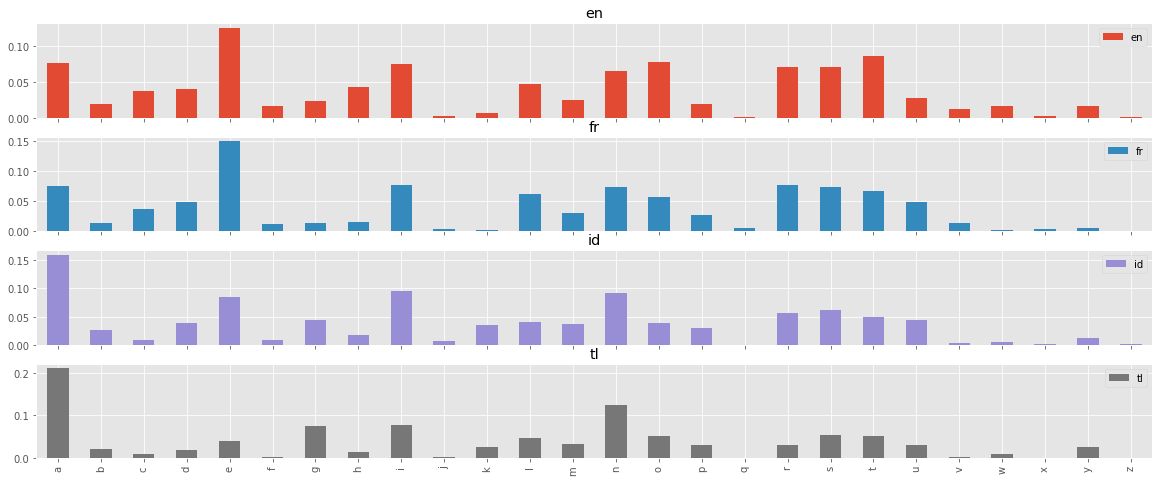

In [30]:
# 시각화 => x축은 a-z(범주형), y축은 빈도비율(수치형)인 차트 => 빈도의 차이를 보여주고 싶다 => 바차트
plt.style.use('ggplot')

df_train_pv.T.plot( kind='bar', subplots=True, figsize=(20,8) )

plt.show()

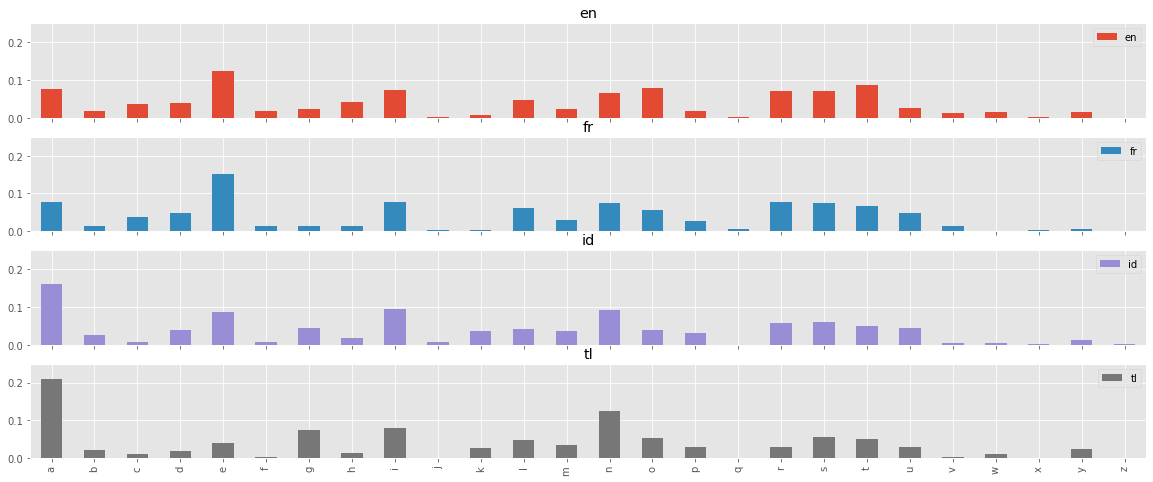

In [31]:
plt.style.use('ggplot')

# y축의 리미트 동일하게 적용 (최소, 최대 + 알파)
df_train_pv.T.plot( kind='bar', subplots=True, figsize=(20,8), ylim=(0, 0.25) )

plt.savefig( 'a_z_per_freqs_by_national.png' )

plt.show()
# 추세는 비슷한데, 디테일한 빈도 비율이 다르다 => 이 차이를 사람이 인지하기는 쉽지 않다
# 이런 개별 문자들간의 디테일한 빈도의 차이를 학습시켜서, 언어 감지를 높은 정확도로 예측할수 있게 진행(머신러닝의 주제에 부합)

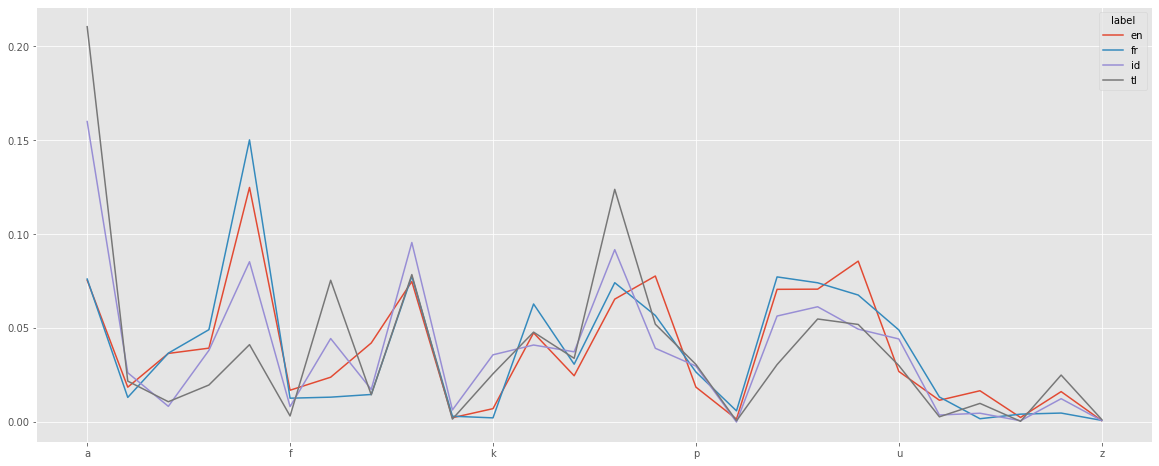

In [32]:
# 추세를 선형그래프로 그려서 확인
df_train_pv.T.plot(kind='line', figsize=(20,8));
# 알파벳을 사용하는 국가들읜 언어내에서 사용 빈도 추세는 유사하게 보인다
# 디테일한 빈도값의 차이는 확실하게 존재한다
# 26개의 문자 내에서 작거나 크게 빈도 차이가 발생하므로 , 이 부분을 학습하면 머신러닝 알고리즘이 잘 분류할것으로 예상됨

In [33]:
df_train.head(2)

,a,b,c,d,e,f,g,h,i,j,...,r,s,t,u,v,w,x,y,z,label
0,0.180053,0.025664,0.008246,0.046101,0.083582,0.005113,0.034121,0.020827,0.088696,0.009058,...,0.056879,0.054380,0.050208,0.043260,0.003003,0.006233,0.000308,0.012921,0.001136,id
1,0.177559,0.022822,0.019018,0.021784,0.064920,0.004927,0.066909,0.019018,0.074516,0.001902,...,0.045902,0.058956,0.054806,0.027835,0.005100,0.008212,0.000864,0.023340,0.002680,tl


In [34]:
df_train.label.unique()

array(['id', 'tl', 'fr', 'en'], dtype=object)

In [35]:
# 전체 데이터중에서 정답이 en인 데이터만 추출하시오
df_train[ df_train.label == 'en' ]

,a,b,c,d,e,f,g,h,i,j,...,r,s,t,u,v,w,x,y,z,label
7,0.075952,0.012840,0.045702,0.046137,0.105332,0.015669,0.019151,0.043743,0.073993,0.001741,...,0.077693,0.061371,0.080522,0.025898,0.009793,0.014146,0.000653,0.020022,0.000435,en
10,0.071646,0.012172,0.045643,0.032642,0.120055,0.014661,0.025173,0.023513,0.094606,0.002490,...,0.053942,0.087967,0.081051,0.029046,0.018811,0.011895,0.000553,0.017981,0.000553,en
11,0.084178,0.019912,0.030404,0.038870,0.136998,0.017408,0.031239,0.027423,0.075355,0.002623,...,0.090140,0.071659,0.077739,0.030643,0.013712,0.013950,0.002027,0.010731,0.000596,en
13,0.072210,0.027715,0.029977,0.039593,0.121041,0.016780,0.023567,0.059012,0.065234,0.001508,...,0.059201,0.073341,0.093703,0.024321,0.005090,0.019608,0.006033,0.017534,0.001697,en
19,0.073806,0.020368,0.031099,0.039641,0.141261,0.020368,0.020368,0.056943,0.065046,0.003285,...,0.072492,0.059571,0.095488,0.024967,0.010731,0.023872,0.003066,0.014893,0.000657,en


In [36]:
# 전체 데이터중에서 정답이 en인 데이터중에서 컬럼이 a인 데이터만 추출하시오
df_train[ df_train.label == 'en' ][ 'a' ]

7     0.075952
10    0.071646
11    0.084178
13    0.072210
19    0.073806
Name: a, dtype: float64

a


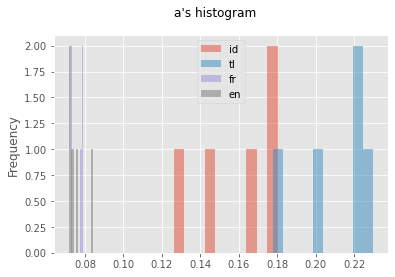

In [37]:
# a의 빈도 개별값 20개를 각각 언어별로 추출해서 그리겠다 
# 언어별로 빈도값의 분포가 다르게 보일것이다!!(확인해보자)

# 개별 문자에 대한 국가별 빈도 분포를 그려서 차이를 비교 =>  히스토그램을 이용하여 겹쳐서 그려본다
# a라는 문자에 대한 국가별 빈도를 그려서 차이를 체크 -> a-z까지
for word in string.ascii_lowercase:
  print( word )
  # 언어별, 문자별 데이터 추출
  # 정답별(언어별)로 데이터를 추출
  for na in df_train.label.unique():
    # 언어별 데이터만 추출 => (5, 27) => [ 'a' ] => (5,)
    tmp = df_train[ df_train.label == na ][ word ]
    tmp.plot( kind='hist', alpha=0.5, label=na) # 히스토그램, 반투명하게 bin을 그리고, 라벨은 언어명을 지정
    #break
  # 범례표기
  plt.legend()
  plt.suptitle(f'{word}\'s histogram')
  plt.savefig(f'{word}_hist.png')
  plt.show()
  break

# 해석 : A라는 문자의 언어별 빈도 분포를 히스토그램으,로 살펴보면
# id와 tl은 구분이 가능, id/tl vs fr/en 구분 가능
# 단, fr/en은 대부분이 겹쳐있다. a의 빈도 만으로는 영어와 프랑스어를 구분하기 어렵다
# 따라서, 다른 문자의 빈도도 체크해서 전체적으로 차이점을 찾아내야 구분이 가능할듯(예상)

# 모델 구축-머신러닝(기계학습-정형화되어있다) 적용

- 파이썬 진영에서 머신러닝 알고리즘 및 도구를 제공하는 패키지
- scikit-learn
  - https://scikit-learn.org/stable/
- 서비스가 적용되는 아나콘다 BASE 상에서 사용 버전
  - 1.0.2
  - 캐글의 scikit-learn 버전도 동일하게 맞춘다

In [38]:
!pip install scikit-learn==1.0.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
import sklearn

sklearn.__version__

'1.0.2'

## 알고리즘 선택

- 선택
  - **경험적**으로 선택 가능
  - 캐글 대회등에서 **가장 많이 사용되는 알고리즘** 선택
  - 알고리즘 선택 시트
  - **베이스라인 구축을 위한 기본 모델(성능에 상관없이) 선택**
    - 이후 전체적인 플로우가 구성되면 최적모델로 교체
- 구성
  - 새로 알고리즘을 만드는가? => 연구 기관,기업,단체 등에서 가능
  - **기존 알고리즘을 최적화하여 사용하는가?**
    - 알고리즘의 조합, 피처 엔지니어링을 활용하여서 해결, 알고리즘의 최적 파라미터 구성
- 특징
  - 알고리즘 선택은 단계상 최초가 아닌 학습 직전에 선택해도 된다

In [40]:
from sklearn import svm

# 알고리즘 선택, 파라미터는 기본값을 사용하겠다
clf = svm.SVC()

clf

SVC()

## 데이터 준비

- **피처 엔지니어링 (특성공학)**

  - 데이터 인코딩
    - 문자 -> 수치화 : 모든 학습 행위는 수치 데이터를 가지고 진행, 반드시 수치로 표현한다

    - 레이블 인코딩
      - 범주형 정답에 순차적으로 숫자를 적용하여 변환
      - 사과(1), 귤(2), 배(3)
      - 단점 : 머신러닝 알고리즘은 사과가 귤에 더 가깝고, 배가 상대적으로 멀다고 느낀다, 1과 이웃한 2가 더 가깝다고 인식

    - 원-핫 인코딩
      - 레이블 인코딩의 보완적인 측면으로 사용
      - 여러값들중에서 하나만 활성화(1) 시켰다, 나머지는 모두 0이 된다
      - 레이블 인코딩 문제 해결
      - 단점 : 고유한 데이터가 많으면 피처가 수가 비례해서 증가한다 -> 연산/메모리 비용 증가 -> 학습 속도 저하 

    - ... 인코딩

  - 피처 스케일링
    - 서로 다른 피처의 값의 범위를 일치하도록 조정
    - 피처들의 값의 범위가 제각각이면, 훈련 자체가 성립이 않되거나 훈련의 결과가 좋지 않게 나올수 있다
    - 종류
      - 표준화 스케일러 : 평균 0, 표준편차 1을 가진 정규 분포를 따르도록 데이터 조정 
      - min-max 스케일러: 최소값 0, 최대값 1로 되겠금 값을 조정

  - 피처 제거
    - 학습 및 예측시 전혀 도움이 않거나, 성과를 저하시키는 요소를 제거

  - 결측치 처리
    - 제거, 개수, 비중, 분포에 따라 데이터로 활용하거나, 보정등등하여 사용 

  - 이상치 제거
  - 파생 피처 생성
    - 기존 피처들을 이용하여 새로운 피처 생성

- 데이터 분류
  - **학습용**
    - 모델 학습시 사용되는 데이터

  - **테스트용**
    - 학습된 모델의 성능을 체크하는 용도
    - 한번도 만나지 않은 데이터

  - **검증용**
    - 과적합 방지용, 학습 성과를 판단하는 용도

  - 통상적으로 아래 비율을 가장 이상적으로 본다(**확정적이진 않음**)
    - 75 : 25 = 학습용 : 테스트용
      - 75(50+25) : 25 = 학습용(훈련용+검증용) : 테스트용
    - 경쟁대회에서는 **다양한 상황으로 제공**

In [41]:
with open('freqs_label.json') as f:
  data = json.load( f )
# data = [ 훈련용, 테스트용 ]
# 훈련용 데이터 20개, 피처 데이터, X로 표기(통상적으로 대문자로 표기)
X = data[0]['freqs']
# 훈련용 데이터 20개, 정답(타겟) 데이터
y = data[0]['labels']

## 학습

- 알고리즘에서 제공하는** fit() 함수**를 활용하여 학습 진행
- 데이터를 직접 공급(**커스텀**)하면서 학습시키는 방법 존재
- 기법
  - **k폴드 교차 검증** 기법 학습
  - **층화 k폴드 교차 검증** 기법 학습
    - 레이블이 불균형할때 사용

- 방식
  - **오프라인 학습**
    - 훈련 따고, 시스템 적용 따로
    - 모델 업그레이드시 시스템 다운후 적용, 재가동(대체가능)
  - 온라인 학습
    - 시스템이 유지되면서 업데이트된 모델이 자동적용되는 방식
    - 리스크가 존재함

In [42]:
# 학습
clf.fit(X, y)

SVC()

## 예측

- 테스트 데이터를 넣어서 모델이 예측 수행
- 한번도 만나지 않은 데이터를 학습된 모델이 예측 행위를 수행

In [43]:
# 테스트 데이터 획득
test_X = data[1]['freqs']

#len(text_X), text_X

# 예측
pred_y = clf.predict( test_X )
pred_y

array(['en', 'id', 'id', 'fr', 'fr', 'en', 'tl', 'tl'], dtype='<U2')

## 성능평가

- 분류
  - 혼동행렬을 통해서 파악
    - 정확도, 정밀도, f1-SCORE, ...
    - auc, roc 
    - 값이 높을수록 좋은 성능을 냄
- 회귀
  - 손실값(실제값과 예측값 사이의 차이값)
    - Mse, Rmse, ...
    - 값이 낮을수록 (0에 가까울수록) 좋은 성능을 낸다

- 경쟁대회에서 제공하는 지표(새로운 함수가 될수도 있음)를 기준으로 판단

In [44]:
# 평가 도구
from sklearn import metrics

# 실제값, 예측값을 넣어서 정확도 측정
metrics.accuracy_score( data[1]['labels'], pred_y )

# 1.0이면 과적합으로 판단한다
# 데이터가 너무 적었기 때문에, 과적합으로 편향될수 있다 -> 데이터를 늘려서 다시 학습,..
# 여기서는 이대로 사용

1.0

In [45]:
# 오차행렬을 이용한 각종 지표 리포트 확인
print( metrics.classification_report( data[1]['labels'], pred_y ) )
# precision    recall  f1-score 지표들이 모두 1.0 
# 과적합이 확실하지만  그대로 진행

              precision    recall  f1-score   support

          en       1.00      1.00      1.00         2
          fr       1.00      1.00      1.00         2
          id       1.00      1.00      1.00         2
          tl       1.00      1.00      1.00         2

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



## 최적화 (이번단계에서는 생략)

- 하이퍼파라미터 튜닝
  - 알고리즘에 들어가는 각종 파라미터중, 튜닝에 해당되는 파라미터들의 값을 조정
- 교차 검증
  - 다양한 알고리즘을 서로 비교 검증하여 최적 알고리즘을 찾는 행위
  - 5개의 알고리즘을 적용, 가장 베스트 스코어를 가진 알고리즘을 선택 -> 이 알고리즘을 최적화 수행
- 파이프라인구축
  - 하이퍼파라미터, 교차검증등을 하나의 시퀀스로 연결하여서 학습 진행
- 피처 엔진니어링

- **최적의 알고리즘, 파라미터, 조합을 찾기 위한 행위**

## 모델 덤프 or 예측결과 제출(캐글)

- 모델을 시스템(서비스)에 서빙하기 위한 덤프 작업
- 파일 형태로 제공

In [46]:
!pip install joblib==1.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [47]:
#from sklearn.externals import joblib
import joblib

joblib.__version__

'1.1.0'

In [48]:
# 모델 덤프 처리
joblib.dump( clf, 'lang_predict.ml' )

['lang_predict.ml']

In [49]:
# 정답 데이터 덤프
target = {
    'en':'영어',
    'fr':'프랑스어',
    'id':'인도네시아어',
    'tl':'타갈리아어',
}

joblib.dump( target, 'lang.label' )

['lang.label']

# 시스템 통합-서비스구축,...

- flask  기반에서 모델을 서빙받아서 언어감지 서비스를 제공한다
- 웹기반 서비스
- vscode 기반에서 진행